In [129]:
import pandas as pd
import seaborn as sns
import json
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet

In [65]:
json_file_path = "/Users/toddhendricks/Downloads/acndata_sessions.json"

with open(json_file_path, 'r') as j:
     data = json.loads(j.read())

In [66]:
df = pd.json_normalize(data['_items'])

Generate a description of the dataset.

In [67]:
charging_slots = df.stationID.nunique()
customers = df.userID.nunique()
total_mwh_delivered = sum(df.kWhDelivered) / 1000

In [68]:
df.columns

Index(['_id', 'clusterID', 'connectionTime', 'disconnectTime',
       'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID',
       'stationID', 'timezone', 'userID', 'userInputs'],
      dtype='object')

Our target is the duration of a charging session represented in minutes. We will need to convert the relevant columns to datetime objects in order to facilitate the math.

In [69]:
df.connectionTime = pd.to_datetime(df.connectionTime)
df.doneChargingTime = pd.to_datetime(df.doneChargingTime)
# air_quality["datetime"] = pd.to_datetime(air_quality["datetime"])

In [70]:
df.connectionTime = pd.to_datetime(df.connectionTime.dt.strftime('%m/%d/%Y %H:%M')) 
df.doneChargingTime = pd.to_datetime(df.doneChargingTime.dt.strftime('%m/%d/%Y %H:%M'))

In [81]:
df['charging_session_duration_in_min'] = df['charging_session_duration'].astype("timedelta64[m]")

In [145]:
df_less_outliers = df[df['charging_session_duration_in_min'] <= 1000]

In [151]:
n = 2
data_lost = (len(df_less_outliers) / len(df)) * 100
print("After removing outliers, we have {0:.{1}f} percent of the data we began with.".format(data_lost, n))

After removing outliers, we have 84.10 percent of the data we began with.


In [104]:
session_length = df_less_outliers['charging_session_duration_in_min']

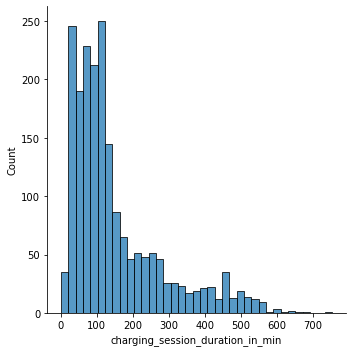

In [106]:
sns.displot(session_length)

Our target is right-skewed which makes intuitive sense. Most of the sessions are short, but there are a few that are very long. From a modeling standpoint, we will consider applying a power transformation at the engineering stage.

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_min'>

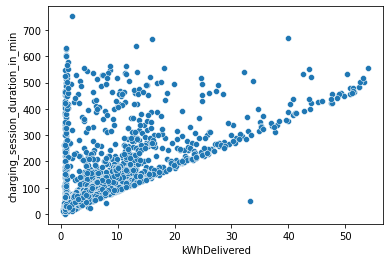

In [107]:
sns.scatterplot(data=df_less_outliers, x='kWhDelivered', y='charging_session_duration_in_min')

The scatterplot reveals an interesting property of the data: there is a limit to how fast a vehicle can be charged - but there's no upper bound. Physics would explain the lower boundary. We do not yet know what covariate(s) explain the variance above the hard lower bound.
The vector of zeros on the X axis is also interesting. There are a considerable number of sessions where the vehicle is supposedly charging - but it is not registering kWh delivered. 

In [110]:
by_parking_slot = df_less_outliers.groupby(by='stationID').mean()

In [115]:
x = by_parking_slot['kWhDelivered']
y = by_parking_slot['charging_session_duration_in_min']

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_min'>

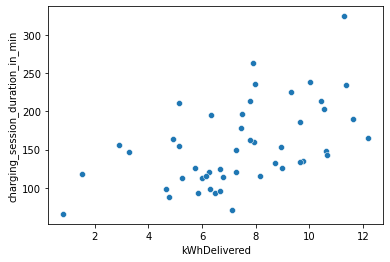

In [116]:
sns.scatterplot(x=x,y=y)

In [125]:
X,y = df_less_outliers['kWhDelivered'], df_less_outliers['charging_session_duration_in_min']
X = X.values.reshape(-1,1)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [127]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [128]:
lr.score(X_test, y_test)

0.2450173116480725